## Modeling Heart Disease

Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn_pandas import DataFrameMapper
from sklearn import (preprocessing, metrics)
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
# from xgboost import XGBClassifier
# from sklearn.decomposition import PCA
from jupyterthemes import jtplot
jtplot.style('grade3')

Read in the 'clean' data from EDA
(One duplicate, and one possible outlier dropped)

In [58]:
data = pd.read_csv('heart_clean.csv')

Normalize continuous data (z-score) so that feature values are on similar scales. (Categorical data values are already on similar scales, so do not require transformation at this time.) 
Split data into training/test sets so test data does not influence z-score normalization.

In [59]:
random_seed = 20
sns.set_style('whitegrid') # Style option for later graphs

In [60]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns='target'), data.target,
                                                    test_size=0.3, stratify=data.target, random_state=random_seed)

In [61]:
#categorical = ['cp', 'restecg', 'slope', 'ca', 'thal']
#binary_cat = ['sex', 'fbs', 'exang'] ## 'target' is omitted
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [62]:
#OH = preprocessing.OneHotEncoder(categories = 'auto', sparse=False)
mapper = DataFrameMapper([([n], preprocessing.StandardScaler()) for n in numerical], default=None, df_out=True)

In [63]:
X_train = mapper.fit_transform(x_train)
X_test = mapper.transform(x_test)

## Model 1: K-Nearest Neighbors
Predicts disease state based on votes from a defined number of nearest neighbors. <br> 
Parameters to be optimized by grid search: 1. k_neighbors - how many neighbors to count, 2. weights - whether or not to weight votes by distance, 3. metric - distance measure <br>


In [64]:
knn = KNeighborsClassifier()

In [65]:
params = {'n_neighbors': [i for i in range(1, 20, 2)], # skip even numbers to avoid ties
          'weights': ['uniform', 'distance'],
          'metric': ['euclidean', 'manhattan']}

In [66]:
# f1 score is selected to measure a balance of precision and recall
# cv and iid are adjusted to match default behaviour of future version sklearn
model = GridSearchCV(knn, params, scoring='f1', return_train_score=True, cv=5, iid=False, verbose = 1)

In [67]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    7.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=False, n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1', verbose=1)

In [68]:
print('Best parameters:', model.best_params_)
print('Best score: {:.3f}'.format(model.best_score_))

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
Best score: 0.865


### Evaluate K-neighbors  parameter optimization and model performance

Plot the train/test results from grid search to evaluate how each of the parameters affected training, and check that the 'best parameters' are reasonable.

In [69]:
# Save selected results in molten form for graphing
res = pd.DataFrame.from_dict(model.cv_results_).melt(
    id_vars = ['param_n_neighbors', 'param_metric', 'param_weights'],
    value_vars = ['mean_test_score', 'mean_train_score'])

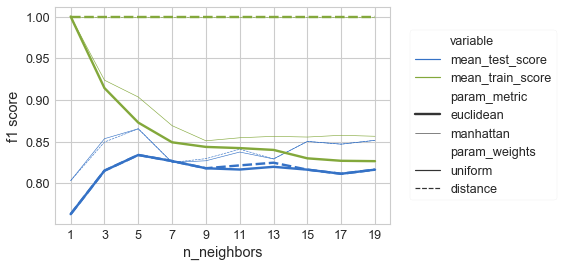

In [70]:
sns.lineplot(x = res.param_n_neighbors, y = res.value, size = res.param_metric, hue = res.variable,
             style = res.param_weights)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left") # move legend outide of grid
plt.xticks(range(1,20,2))
plt.ylabel('f1 score')
plt.xlabel('n_neighbors');

1. k_neighbors: The 'elbow' where the train and test scores converge appears around k=5-7 <br> 
2. weights: Test scores were hardly affected, but weighting by distance completely overestimated the training score, making 'uniform' a better choice. <br>
3. metric: Manhattan scores are consistently (slightly) higher than euclidean. However the euclidean curves are smooth, while manhattan are somewhat erratic, indicating they could be overfit. <br>
Overall, the parameters selected during training (k=5, weights=uniform, and metric=manhattan) appear reasonable.

The model was refit with the best parameters found during grid search, so can be used predict labels for test data and evaluate performance.

In [71]:
y_pred = model.predict(X_test)

In [72]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80        42
           1       0.81      0.88      0.84        49

    accuracy                           0.82        91
   macro avg       0.83      0.82      0.82        91
weighted avg       0.83      0.82      0.82        91



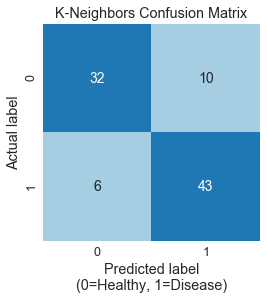

In [73]:
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), cmap=sns.color_palette('Paired', 2),
            annot=True, annot_kws={'size':14}, cbar=False, square=True)
plt.xlabel('Predicted label\n(0=Healthy, 1=Disease)')
plt.ylabel('Actual label')
plt.title('K-Neighbors Confusion Matrix');

Precision and recall are fairly balanced. The model tends to over-predict presence of heart disease (false positives).

## Model 2: Linear Support Vector Classification
As suggested by the scikit-learn guide: [Choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

In [74]:
# dual=False is preferred when n_samples > n_features
# when dual=False, implementation is not random so do not need to set random_state
clf = LinearSVC(dual=False, verbose=1)
c_params = {'n_neighbors': [i for i in range(1, 20, 2)], # skip even numbers to avoid ties
          'weights': ['uniform', 'distance'],
          'metric': ['euclidean', 'manhattan']}

In [75]:
clf.fit(X_train, y_train)

[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=1)

In [76]:
c_pred = clf.predict(X_test)

In [77]:
print(metrics.classification_report(y_test, c_pred))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85        42
           1       0.84      0.94      0.88        49

    accuracy                           0.87        91
   macro avg       0.88      0.86      0.87        91
weighted avg       0.87      0.87      0.87        91



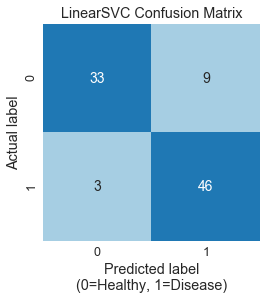

In [78]:
sns.heatmap(metrics.confusion_matrix(y_test, c_pred), cmap=sns.color_palette('Paired', 2),
            annot=True, annot_kws={'size':14}, cbar=False, square=True)
plt.xlabel('Predicted label\n(0=Healthy, 1=Disease)')
plt.ylabel('Actual label')
plt.title('LinearSVC Confusion Matrix');

In [79]:
from sklearn.model_selection import (cross_validate, cross_val_score)

In [80]:
clf_cv = cross_validate(clf, X_train, y_train, cv=5, scoring='f1', return_train_score=True)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [81]:
# Compare f1 scores from cross-validaton and the trained model
print('Average CV train score: {:.3f}'.format(clf_cv['train_score'].mean()))
print('Average CV test score: {:.3f}'.format(clf_cv['test_score'].mean()))
print('Model train score: {:.3f}'.format(metrics.f1_score(y_train, clf.predict(X_train))))
print('Model test score: {:.3f}'.format(metrics.f1_score(y_test, c_pred)))

Average CV train score: 0.865
Average CV test score: 0.851
Model train score: 0.867
Model test score: 0.885


The LinearSVC model is more accurate than the K-neighbors, with improved precision and recall for both 'healthy' and 'heart disease' labels. The model still tends towards type 1 error. <br>
One caveat is that the test score (f1 = 0.885) is higher than the model train score, and both of the cross-validation average scores. I expect this is due to this particular train/test split. As the CV and model train scores are very similar, actual performance of the model would likely be in line with the cross-validation test score (~ 0.851). 

## Model 3: Random Forest

In [82]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier)

In [83]:
# n_estimators=100 to match default for future version of sklearn
rfc = RandomForestClassifier(n_estimators=100, random_state=random_seed)

In [84]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

In [85]:
r_pred = rfc.predict(X_test)

In [86]:
print(metrics.classification_report(y_test, r_pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80        42
           1       0.82      0.86      0.84        49

    accuracy                           0.82        91
   macro avg       0.82      0.82      0.82        91
weighted avg       0.82      0.82      0.82        91



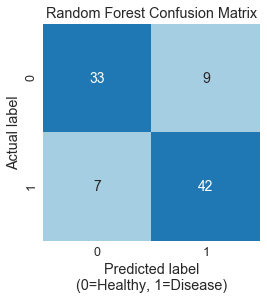

In [87]:
sns.heatmap(metrics.confusion_matrix(y_test, r_pred), cmap=sns.color_palette('Paired', 2),
            annot=True, annot_kws={'size':14}, cbar=False, square=True)
plt.xlabel('Predicted label\n(0=Healthy, 1=Disease)')
plt.ylabel('Actual label')
plt.title('Random Forest Confusion Matrix');

In [88]:
# Show which features were most influential
pd.DataFrame(rfc.feature_importances_, index=X_train.columns).sort_values(by=0,ascending=False).rename(
    columns={0:'feat_import'})

,feat_import
thalach,0.142521
ca,0.125554
thal,0.112817
cp,0.109039
oldpeak,0.098938
age,0.085050
trestbps,0.081833
chol,0.075188
exang,0.056960
sex,0.044788


In [89]:
metrics.accuracy_score(y_test, rfc.predict(X_test))

0.8241758241758241

In [90]:
rfc.score(X_test, y_test)

0.8241758241758241

In [91]:
rfc_cv = cross_validate(rfc, X_train, y_train, cv=5, scoring='f1', return_train_score=True)

In [92]:
# Compare f1 scores from cross-validaton and the trained model
print('Average CV train score: {:.3f}'.format(rfc_cv['train_score'].mean()))
print('Average CV test score: {:.3f}'.format(rfc_cv['test_score'].mean()))
print('Model train score: {:.3f}'.format(metrics.f1_score(y_train, rfc.predict(X_train))))
print('Model test score: {:.3f}'.format(metrics.f1_score(y_test, r_pred)))

Average CV train score: 1.000
Average CV test score: 0.829
Model train score: 1.000
Model test score: 0.840


Performance for unoptimized random forest classifier is slightly worse than for LinearSVC (due to increase in false negatives). The model appears overfit to the training data. Try reducing leaf depth to generalize the model. 

In [93]:
rfc_params = {'criterion': ['gini', 'entropy'],
              'max_depth': [i for i in range(1, 21)]}

In [109]:
rfc_opt = GridSearchCV(rfc, param_grid=rfc_params, scoring='roc_auc', cv=5, iid=False, return_train_score=True, verbose=1)

In [110]:
rfc_opt.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   29.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=20,
                                              verbose=0, warm_start=False),
             iid=False, n_jobs=None,
             param_grid={'crit

In [111]:
print('Best parameters:', rfc_opt.best_params_)
print('Best score: {:.3f}'.format(rfc_opt.best_score_))

Best parameters: {'criterion': 'entropy', 'max_depth': 5}
Best score: 0.912


In [112]:
rfc_opt.score(X_test, y_test)

0.901846452866861

In [98]:
ro_pred = rfc_opt.predict(X_test)
print(metrics.classification_report(y_test, ro_pred))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84        42
           1       0.83      0.92      0.87        49

    accuracy                           0.86        91
   macro avg       0.86      0.85      0.85        91
weighted avg       0.86      0.86      0.86        91



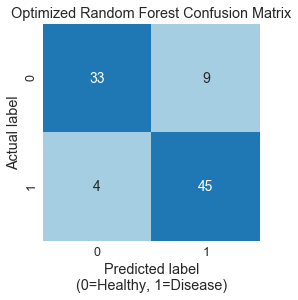

In [99]:
sns.heatmap(metrics.confusion_matrix(y_test, ro_pred), cmap=sns.color_palette('Paired', 2),
            annot=True, annot_kws={'size':14}, cbar=False, square=True)
plt.xlabel('Predicted label\n(0=Healthy, 1=Disease)')
plt.ylabel('Actual label')
plt.title('Optimized Random Forest Confusion Matrix');

In [100]:
abc = AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=2, criterion='entropy', n_estimators=100), n_estimators=100, random_state=random_seed)

In [101]:
abc.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=2,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         n_estimators=100,
                        

In [102]:
a_pred = abc.predict(X_test)

In [103]:
print(metrics.classification_report(y_test, a_pred))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73        42
           1       0.77      0.76      0.76        49

    accuracy                           0.75        91
   macro avg       0.75      0.75      0.75        91
weighted avg       0.75      0.75      0.75        91



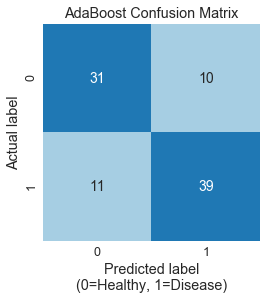

In [48]:
sns.heatmap(metrics.confusion_matrix(y_test, a_pred), cmap=sns.color_palette('Paired', 2),
            annot=True, annot_kws={'size':14}, cbar=False, square=True)
plt.xlabel('Predicted label\n(0=Healthy, 1=Disease)')
plt.ylabel('Actual label')
plt.title('AdaBoost Confusion Matrix');

In [49]:
abc_cv = cross_validate(abc, X_train, y_train, cv=5, scoring='f1', return_train_score=True)

In [50]:
# Compare f1 scores from cross-validaton and the trained model
print('Average CV train score: {:.3f}'.format(abc_cv['train_score'].mean()))
print('Average CV test score: {:.3f}'.format(abc_cv['test_score'].mean()))
print('Model train score: {:.3f}'.format(metrics.f1_score(y_train, abc.predict(X_train))))
print('Model test score: {:.3f}'.format(metrics.f1_score(y_test, a_pred)))

Average CV train score: 1.000
Average CV test score: 0.817
Model train score: 1.000
Model test score: 0.788


In [104]:
gbc = GradientBoostingClassifier(n_estimators=1000, random_state=random_seed)

In [105]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='auto',
                           random_state=20, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [106]:
g_pred = gbc.predict(X_test)

In [107]:
print(metrics.classification_report(y_test, g_pred))

              precision    recall  f1-score   support

           0       0.78      0.69      0.73        42
           1       0.76      0.84      0.80        49

    accuracy                           0.77        91
   macro avg       0.77      0.76      0.77        91
weighted avg       0.77      0.77      0.77        91



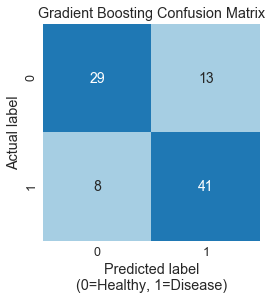

In [108]:
sns.heatmap(metrics.confusion_matrix(y_test, g_pred), cmap=sns.color_palette('Paired', 2),
            annot=True, annot_kws={'size':14}, cbar=False, square=True)
plt.xlabel('Predicted label\n(0=Healthy, 1=Disease)')
plt.ylabel('Actual label')
plt.title('Gradient Boosting Confusion Matrix');

In [56]:
gbc_cv = cross_validate(gbc, X_train, y_train, cv=5, scoring='f1', return_train_score=True)

In [57]:
# Compare f1 scores from cross-validaton and the trained model
print('Average CV train score: {:.3f}'.format(gbc_cv['train_score'].mean()))
print('Average CV test score: {:.3f}'.format(gbc_cv['test_score'].mean()))
print('Model train score: {:.3f}'.format(metrics.f1_score(y_train, gbc.predict(X_train))))
print('Model test score: {:.3f}'.format(metrics.f1_score(y_test, g_pred)))

Average CV train score: 1.000
Average CV test score: 0.794
Model train score: 1.000
Model test score: 0.808
